In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tvt
import torch_directml
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from pycocotools.coco import COCO
import numpy as np
from PIL import Image
import random, os, time
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# dml = torch_directml.device()
dml = torch.device('cpu')

In [10]:
class MyDataset(torch.utils.data.Dataset):
    xform = tvt.Compose([
        tvt.ToTensor(),
        # transform to range [-1, 1]:
        tvt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ])

    # read COCO data from coco_dir, resize them and write to save_dir
    def __init__(self, *, 
                 coco_dir="/home/parry/gitRepos/homeworks_ECE_60146/hw4_YuxinSun/coco", 
                 save_dir="/home/parry/gitRepos/homeworks_ECE_60146/hw4_YuxinSun/resized",
                 train_num=1500, test_num=500, \
                 catType=['airplane','bus','cat','dog','pizza'], update=False
        ):
        dataDir  = coco_dir
        prefix   = 'instances'
        dataType = 'train2014'
        annFile  = '%s/annotations/%s_%s.json'%(dataDir,prefix,dataType)
        cocoGt   = COCO(annFile)

        self.train_num = train_num
        self.test_num  = test_num
        self.dir = save_dir

        # [17, 18, 5...] to [0, 1, 2...]
        self.catId_to_label = {cocoGt.getCatIds(catType[i])[0]: i  for i in range(len(catType))}

        # [0, 1, 2...] to ['cat', 'dog', ...]
        self.label_to_cat = {i: catType[i] for i in range(len(catType))}

        self.data, self.labels = self.gen_data_id(cocoGt, catType)
        self.gen_resized_image(cocoGt, dataDir, update=update)

    # return data and label(data are actually categoryIDs)
    def gen_data_id(self, cocoGt, catType):
        catIds = cocoGt.getCatIds(catNms=catType)
        sets = [set(cocoGt.getImgIds(catIds=catIds[i])) for i in range(len(catType))]
        rg = [(i, len(sets[i]), catIds[i]) for i in range(len(catType))]
        rg.sort(key=lambda x: x[1])

        cat_sets = []
        m = self.train_num
        k = self.test_num
        n = self.train_num+self.test_num
        labels = [0]*(n*len(catType))
        data = [0]*len(labels)
        for (i, length, cat)  in rg:
            s = sets[i]
            for s2 in cat_sets:
                # subtraction between two set() object
                s = s - s2
            ids = random.sample(s,n)
            cat_sets.append(set(ids))
            labels[i*m:(i+1)*m] = [cat]*m
            data[i*m:(i+1)*m] = ids[:m]
            labels[i*k+len(catType)*m:(i+1)*k+len(catType)*m] = [cat]*k
            data[i*k+len(catType)*m:(i+1)*k+len(catType)*m] = ids[m:]
        return cocoGt.loadImgs(data), labels

    # resize data. if resized data exist and update=False, we will not overwrite images.
    def gen_resized_image(self, cocoGt, dataDir, new_size=(64,64), update=False):
        for im in self.data:
            orig_path = '%s/%s/%s'%(dataDir, 'train2014', im['file_name'])
            save_path = '%s/%s'%(self.dir, im['file_name'])
            if update or not os.path.exists(save_path):
                img = Image.open(orig_path)
                if img.mode != 'RGB':
                    # force update if it is not RGB
                    img = img.convert('RGB')
                img = img.resize(new_size,resample=Image.Resampling.LANCZOS)
                img.save(save_path)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        pil_image = Image.open('%s/%s'%(self.dir, self.data[index]['file_name']))
        tensor_img = self.xform(pil_image)
        tensor_lab = self.catId_to_label[self.labels[index]]
        return tensor_img, tensor_lab
    
def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            if isinstance(img, Image.Image):
                ax.imshow(img, **imshow_kwargs)
            else:
                ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()



classes = ['pizza','airplane','bus','cat','dog']
dataset = MyDataset(update=False, catType=classes)


loading annotations into memory...
Done (t=5.15s)
creating index...
index created!


In [14]:
device = dml

class MasterEncoder(nn.Module):
    def __init__(self, max_seq_length, embedding_size, how_many_basic_encoders, num_atten_heads):
        super().__init__()
        self.max_seq_length = max_seq_length
        self.basic_encoder_arr = nn.ModuleList([BasicEncoder(
            max_seq_length, embedding_size, num_atten_heads) for _ in range(how_many_basic_encoders)])  # (A)

    def forward(self, sentence_tensor):
        out_tensor = sentence_tensor
        for i in range(len(self.basic_encoder_arr)):  # (B)
            out_tensor = self.basic_encoder_arr[i](out_tensor)
        return out_tensor


class BasicEncoder(nn.Module):
    def __init__(self, max_seq_length, embedding_size, num_atten_heads):
        super().__init__()
        self.max_seq_length = max_seq_length
        self.embedding_size = embedding_size
        self.qkv_size = self.embedding_size // num_atten_heads
        self.num_atten_heads = num_atten_heads
        self.self_attention_layer = SelfAttention2(
            max_seq_length, embedding_size, num_atten_heads)  # (A)
        self.norm1 = nn.LayerNorm(self.embedding_size)  # (C)
        self.W1 = nn.Linear(self.max_seq_length * self.embedding_size,
                            self.max_seq_length * 2 * self.embedding_size)
        self.W2 = nn.Linear(self.max_seq_length * 2 * self.embedding_size,
                            self.max_seq_length * self.embedding_size)
        self.norm2 = nn.LayerNorm(self.embedding_size)  # (E)

    def forward(self, sentence_tensor):
        input_for_self_atten = sentence_tensor.float().to(device)
        normed_input_self_atten = self.norm1(input_for_self_atten)
        output_self_atten = self.self_attention_layer(
            normed_input_self_atten).to(device)  # (F)
        input_for_FFN = output_self_atten + input_for_self_atten # (?)
        normed_input_FFN = self.norm2(input_for_FFN)  # (I)
        basic_encoder_out = nn.ReLU()(
            self.W1(normed_input_FFN.view(sentence_tensor.shape[0], -1)))  # (K)
        basic_encoder_out = self.W2(basic_encoder_out)  # (L)
        basic_encoder_out = basic_encoder_out.view(
            sentence_tensor.shape[0], self.max_seq_length, self.embedding_size)
        basic_encoder_out = basic_encoder_out + input_for_FFN
        return basic_encoder_out

####################################  Self Attention Code TransformerPreLN ###########################################

class SelfAttention(nn.Module):
    def __init__(self, max_seq_length, embedding_size, num_atten_heads):
        super().__init__()
        self.max_seq_length = max_seq_length
        self.embedding_size = embedding_size
        self.num_atten_heads = num_atten_heads
        self.qkv_size = self.embedding_size // num_atten_heads
        self.attention_heads_arr = nn.ModuleList([AttentionHead(self.max_seq_length,
                                                                self.qkv_size) for _ in range(num_atten_heads)])  # (A)

    def forward(self, sentence_tensor):  # (B)
        concat_out_from_atten_heads = torch.zeros(sentence_tensor.shape[0], self.max_seq_length,
                                                  self.num_atten_heads * self.qkv_size).float()
        for i in range(self.num_atten_heads):  # (C)
            sentence_tensor_portion = sentence_tensor[:,
                                                      :, i * self.qkv_size: (i+1) * self.qkv_size]
            concat_out_from_atten_heads[:, :, i * self.qkv_size: (i+1) * self.qkv_size] =          \
                self.attention_heads_arr[i](sentence_tensor_portion)  # (D)
        return concat_out_from_atten_heads

class SelfAttention2(nn.Module):
    def __init__(self, max_seq_length, embedding_size, num_atten_heads):
        super().__init__()
        self.max_seq_length = max_seq_length
        self.embedding_size = embedding_size
        self.num_atten_heads = num_atten_heads
        self.qkv_size = self.embedding_size // num_atten_heads
        # we only need one attention head by using the following tensor:
        self.wqkv_tensor = nn.Parameter(
            torch.randn(num_atten_heads, 3, max_seq_length, self.qkv_size, max_seq_length, self.qkv_size),
            requires_grad=True
        ).to(device)
        self.coeff = 1.0/torch.sqrt(torch.tensor(self.qkv_size).float()).to(device)

    def forward(self, sentence_tensor):
        b, s, d = sentence_tensor.shape
        x = sentence_tensor.view(b, s, self.num_atten_heads, self.qkv_size)
        # b: batch index, 
        # s: sequence index, si sj --> i j
        # h: attention-head index,
        # q: S_{qkv}
        q, k, v = tuple(torch.einsum('bshq,hksqSQ->kbhSQ', x, self.wqkv_tensor))
        QK_dot_prod = torch.einsum('bhiq,bhjq->bhij', q, k)
        rowwise_softmax_normalizations = torch.softmax(QK_dot_prod, dim=-1)
        z = torch.einsum('bhsj,bhjq->bshq', rowwise_softmax_normalizations, v)
        z = self.coeff * z.reshape(b,s,d)
        return z


class AttentionHead(nn.Module):
    def __init__(self, max_seq_length, qkv_size):
        super().__init__()
        self.qkv_size = qkv_size
        self.max_seq_length = max_seq_length
        self.WQ = nn.Linear(max_seq_length * self.qkv_size,
                            max_seq_length * self.qkv_size)  # (B)
        self.WK = nn.Linear(max_seq_length * self.qkv_size,
                            max_seq_length * self.qkv_size)  # (C)
        self.WV = nn.Linear(max_seq_length * self.qkv_size,
                            max_seq_length * self.qkv_size)  # (D)
        self.softmax = nn.Softmax(dim=1)  # (E)

    def forward(self, sentence_portion):  # (F)
        Q = self.WQ(sentence_portion.reshape(
            sentence_portion.shape[0], -1).float()).to(device)  # (G)
        K = self.WK(sentence_portion.reshape(
            sentence_portion.shape[0], -1).float()).to(device)  # (H)
        V = self.WV(sentence_portion.reshape(
            sentence_portion.shape[0], -1).float()).to(device)  # (I)
        Q = Q.view(sentence_portion.shape[0],
                   self.max_seq_length, self.qkv_size)  # (J)
        K = K.view(sentence_portion.shape[0],
                   self.max_seq_length, self.qkv_size)  # (K)
        V = V.view(sentence_portion.shape[0],
                   self.max_seq_length, self.qkv_size)  # (L)
        A = K.transpose(2, 1)  # (M)
        QK_dot_prod = Q @ A  # (N)
        rowwise_softmax_normalizations = self.softmax(QK_dot_prod)  # (O)
        Z = rowwise_softmax_normalizations @ V
        coeff = 1.0/torch.sqrt(torch.tensor([self.qkv_size]).float()).to(device)  # (S)
        Z = coeff * Z  # (T)
        return Z


In [15]:
class ViT(nn.Module):
    def __init__(self, *, max_seq_length=17, embedding_size=64, encoders=2, num_atten_heads=4, 
                 device="cpu"):
        super().__init__()
        self.encorder = MasterEncoder(max_seq_length, embedding_size, encoders, num_atten_heads)
        # tarnsform sentences to embeddings:
        self.embedding = nn.Sequential(
            nn.Conv2d(3, embedding_size, 16, stride=16, padding=0),
            nn.Flatten(start_dim=2, end_dim=-1)
        )
        self.class_head = nn.Parameter(torch.randn(embedding_size, device=device), requires_grad=True)
        self.position = nn.Parameter(2*torch.rand(max_seq_length, embedding_size, device=device)-1,requires_grad=True)
        # MLP with only one hidden layer is enough
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(max_seq_length*embedding_size, 128),
            nn.ReLU(),
            nn.Linear(128, 5)
        )

    def forward(self, x):
        # x_out is of (B, 16, D)
        x = self.embedding(x).transpose(1,2)
        # class_head: (B,  1, D)
        class_head = self.class_head.repeat(x.shape[0],1,1)
        
        x = torch.cat((x, class_head), dim=1).add(self.position)
        x = self.encorder(x)
        out = self.mlp(x)
        return out
        
    def train(self, p):
        # p contains all the runtime parameters
        self.device = p.device
        net = self.to(p.device)
        start_time = time.perf_counter()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(net.parameters(), lr=p.lr, betas=p.betas)
        loss_record = []
        for epoch in range(1, p.epoch_size+1):
            running_loss = 0.
            epoch_start_time = time.perf_counter()
            for i, data in enumerate(p.train_dataloader):
                img_tensor, label_tensor = data
                img_tensor = img_tensor.to(p.device)
                label_tensor = label_tensor.to(p.device)
                optimizer.zero_grad()
                output = net(img_tensor)
                loss = criterion(output, label_tensor)
                running_loss += loss.item()
                loss.backward()
                optimizer.step()
                j = i+1
                if j % p.measure_rate == 0:
                    avg_loss = running_loss/p.measure_rate
                    running_loss = 0.
                    loss_record.append(avg_loss)
                    current_time = time.perf_counter()
                    time_elapsed = current_time - epoch_start_time
                    print("[epoch:%d/%d] [iter:%4d] elapsed time:%4d secs   loss: %.5f"\
                        %(epoch, p.epoch_size, j, time_elapsed, avg_loss) )
    
        time_stamp = '_'.join(time.ctime().split(" ")[1:4])
        saved_model = p.save_dir + "saved_model_" + time_stamp
        torch.save(net.state_dict(), saved_model)
        print("model.state_dict() saved to ", saved_model)
        saved_file = p.save_dir + "saved_file_" + time_stamp
        with open(saved_file, 'w') as f:
            for loss in loss_record:
                f.write("%.5f\n" % loss)
            f.flush()
        total_time = time.perf_counter() - start_time
        print("Total training time: %5d secs"%total_time)
        return loss_record, time_stamp


    def test(self, p, time_stamp):

        self.load_state_dict(torch.load(p.save_dir + "saved_model_" + time_stamp))
        self.device = p.device
        net = self.to(p.device)
        accuracy = 0
        cf_matrix = torch.zeros(5,5)
        with torch.no_grad():
            for i, data in enumerate(p.test_dataloader):
                img_tensor, label_tensor = data
                img_tensor = img_tensor.to(p.device)
                label_tensor = label_tensor.to(p.device)
                output = net(img_tensor)
                predicted_idx = torch.argmax(output, dim=1)
                for label,prediction in zip(label_tensor,predicted_idx):
                    cf_matrix[label][prediction] += 1
                    if label == prediction:
                        accuracy += 1
        accuracy = float(accuracy) / sum(cf_matrix.view(-1))
        print("Accuracy: %0.2f%%"%(accuracy*100))
        return cf_matrix

    class Parameters(object):
        def __init__(self, device, save_dir, dataset, batch_size=32, epoch_size=1,\
                    *, lr=1e-3, betas=(0.9, 0.99), measure_rate=200 ):
            self.device = device
            self.save_dir = save_dir
            self.epoch_size = epoch_size
            self.batch_size = batch_size
            self.lr = lr
            self.betas = betas

            train_num = dataset.train_num
            test_num = dataset.test_num
            classes = dataset.label_to_cat
            split = train_num*len(classes)
            indices = list(range((train_num+test_num)*len(classes)))
            train_indices, test_indices = indices[:split], indices[split:]
            train_sampler = SubsetRandomSampler(train_indices)
            test_sampler = SubsetRandomSampler(test_indices)
            self.train_dataloader =  torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, num_workers=4,
                                           sampler=train_sampler)
            self.test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, num_workers=4,
                                           sampler=test_sampler)
            self.measure_rate = measure_rate

params = ViT.Parameters(
    dml,
    "/home/parry/gitRepos/homeworks_ECE_60146/hw9_YuxinSun/",
    dataset,
    batch_size=16,
    epoch_size=15,
    lr=1e-4,
    betas=(0.9, 0.99),
    measure_rate=20
)

net = ViT(device=dml)

In [16]:
loss, time_stamp = net.train(params)

[epoch:1/15] [iter:  20] elapsed time:   1 secs   loss: 1.97565
[epoch:1/15] [iter:  40] elapsed time:   2 secs   loss: 1.79683
[epoch:1/15] [iter:  60] elapsed time:   3 secs   loss: 1.65854
[epoch:1/15] [iter:  80] elapsed time:   4 secs   loss: 1.60108
[epoch:1/15] [iter: 100] elapsed time:   5 secs   loss: 1.66402
[epoch:1/15] [iter: 120] elapsed time:   6 secs   loss: 1.47078
[epoch:1/15] [iter: 140] elapsed time:   6 secs   loss: 1.64726
[epoch:1/15] [iter: 160] elapsed time:   7 secs   loss: 1.46685
[epoch:1/15] [iter: 180] elapsed time:   8 secs   loss: 1.47914
[epoch:1/15] [iter: 200] elapsed time:   9 secs   loss: 1.45378
[epoch:1/15] [iter: 220] elapsed time:  10 secs   loss: 1.50574
[epoch:1/15] [iter: 240] elapsed time:  11 secs   loss: 1.42202
[epoch:1/15] [iter: 260] elapsed time:  12 secs   loss: 1.38124
[epoch:1/15] [iter: 280] elapsed time:  13 secs   loss: 1.51402
[epoch:1/15] [iter: 300] elapsed time:  14 secs   loss: 1.44709
[epoch:1/15] [iter: 320] elapsed time:  

Accuracy: 44.92%


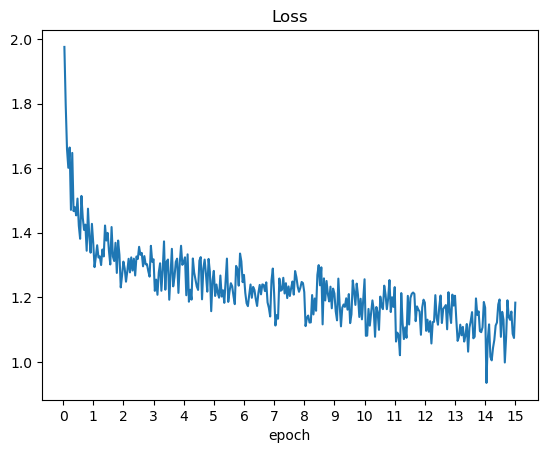

tensor([[281.,  11.,  37., 101.,  70.],
        [ 21., 337.,  69.,  19.,  54.],
        [ 43.,  69., 225.,  73.,  90.],
        [124.,  28.,  80., 170.,  98.],
        [105.,  69.,  93., 123., 110.]])


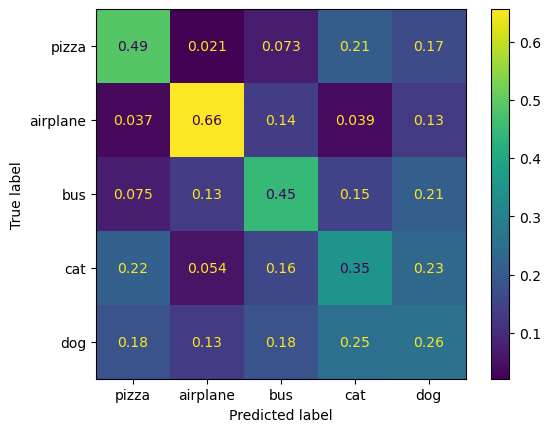

In [17]:
cf_matrix = net.test(params, time_stamp)

# %%
l = len(loss)
plt.plot(np.array(range(1,l+1))/l*params.epoch_size,loss)
plt.xlabel("epoch")
plt.xticks(np.array(range(params.epoch_size+1)))
plt.title("Loss")
plt.show()

# %%
print(cf_matrix)
arr = np.array(cf_matrix)
arr = arr / np.linalg.norm(arr, ord=1, axis=0)
cf = ConfusionMatrixDisplay(arr, display_labels=['pizza','airplane','bus','cat','dog'])
cf.plot()
plt.show()